In [34]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats import pearsonr

In [42]:
df = pd.read_csv('incidents.csv', sep=',', index_col=0) #alternative in case of json source df.to_json('filename.json')
df
df.columns


/var/folders/9b/4rjbcrys1931nh3fmqsfh8740000gn/T/ipykernel_39205/1389857224.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('incidents.csv', sep=',', index_col=0) #alternative in case of json source df.to_json('filename.json')


Index(['state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'state_house_district',
       'state_senate_district', 'participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'notes',
       'incident_characteristics1', 'incident_characteristics2'],
      dtype='object')

In [36]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 239677 entries, 2015-05-02 to 2016-06-12
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   state                      239677 non-null  object 
 1   city_or_county             239677 non-null  object 
 2   address                    223180 non-null  object 
 3   latitude                   231754 non-null  float64
 4   longitude                  231754 non-null  float64
 5   congressional_district     227733 non-null  float64
 6   state_house_district       200905 non-null  float64
 7   state_senate_district      207342 non-null  float64
 8   participant_age1           147379 non-null  float64
 9   participant_age_group1     197558 non-null  object 
 10  participant_gender1        203315 non-null  object 
 11  min_age_participants       164879 non-null  object 
 12  avg_age_participants       165057 non-null  object 
 13  max_age_participants 

In [37]:
df_no_missing = df.dropna(inplace=False)
df_no_missing


,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,participant_age_group1,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
date,,,,,,,,,,,,,,,,,,,,,
2018-01-25,Louisiana,Zachary,18733 Samuels Rd,30.6069,-91.2270,6.0,63.0,15.0,30.0,Adult 18+,...,5.0,0.0,2,1,2.0,0.0,5.0,Good Samaritan shot aggressors - was arrested ...,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)"
2016-08-01,Virginia,Stafford,Cool Springs Road and North Kings Highway,38.3008,-77.4469,1.0,28.0,28.0,65.0,Adult 18+,...,1.0,0.0,1,0,0.0,0.0,1.0,"car crash, suspect holding handgun, officers s...","Shot - Dead (murder, accidental, suicide)",Officer Involved Incident
2015-03-22,Oklahoma,Tulsa,12500 block of East 52nd Street,36.1060,-96.0764,1.0,66.0,37.0,20.0,Adult 18+,...,0.0,1.0,0,1,0.0,0.0,1.0,Super 8 Motel,Shot - Wounded/Injured,Accidental Shooting
2016-12-21,Missouri,Kansas City (Raytown),6500 block of Raytown Road,38.9647,-94.4654,5.0,29.0,9.0,29.0,Adult 18+,...,1.0,0.0,0,0,1.0,0.0,1.0,Suspect fired shots at another man; no shots f...,Shots Fired - No Injuries,Officer Involved Incident
2016-07-08,Illinois,Chicago,500 block of North Lavergne,41.8895,-87.7507,7.0,8.0,4.0,59.0,Adult 18+,...,3.0,0.0,1,2,0.0,0.0,3.0,"Austin - 1 killed, 2 stable;",Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-27,Tennessee,Nashville,500 block of Lemont Drive,36.2291,-86.7435,5.0,54.0,19.0,27.0,Adult 18+,...,1.0,0.0,0,1,0.0,0.0,1.0,"north Nashville, man found shot inside his car",Shot - Wounded/Injured,Drug involvement
2014-08-02,South Dakota,Rapid City,900 block of Fillmore Street,44.0906,-103.2300,1.0,34.0,34.0,57.0,Adult 18+,...,1.0,1.0,2,0,0.0,0.0,2.0,"Perpetrator shot and killed victim, then herself.","Shot - Dead (murder, accidental, suicide)",Suicide^
2015-12-12,New York,Kingston,50 Charlotte Street,41.9414,-74.0025,19.0,103.0,46.0,21.0,Adult 18+,...,1.0,0.0,0,0,1.0,0.0,1.0,Threat people with 380 cal handgun,Non-Shooting Incident,Possession (gun(s) found during commission of ...


In [38]:
#dp_df = df[df.duplicated(keep=False)]
#dp_df = df.groupby(['date','latitude','longitude']).any()
dp_df = df.drop_duplicates()
dp_df



,state,city_or_county,address,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,participant_age_group1,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2
date,,,,,,,,,,,,,,,,,,,,,
2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,94.0,33.0,19.0,Adult 18+,...,1.0,0.0,0,1,0.0,0.0,1.0,Teen wounded while walking - Security guard at...,Shot - Wounded/Injured,NaN
2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,NaN,NaN,62.0,Adult 18+,...,1.0,0.0,1,0,0.0,0.0,1.0,shot self after accident,"Shot - Dead (murder, accidental, suicide)",Suicide^
2016-11-05,Michigan,Detroit,6200 Block of East McNichols Road,42.4190,-83.0393,14.0,4.0,2.0,NaN,NaN,...,NaN,NaN,0,1,0.0,1.0,2.0,1 inj.,Shot - Wounded/Injured,NaN
2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,NaN,NaN,NaN,Adult 18+,...,1.0,0.0,0,1,0.0,0.0,2.0,NaN,Shot - Wounded/Injured,NaN
2030-06-14,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,NaN,NaN,NaN,Adult 18+,...,1.0,0.0,0,1,0.0,1.0,2.0,NaN,Shot - Wounded/Injured,"Drive-by (car to street, car to car)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-11,Tennessee,Murfreesboro,Hazelwood Street,35.8624,-86.3695,4.0,37.0,14.0,NaN,Adult 18+,...,1.0,0.0,0,1,0.0,0.0,1.0,"Tried to grab gun as it fell, shot self in foot.",Shot - Wounded/Injured,Non-Aggression Incident
2029-01-01,New York,Troy,Pawling and Plum Avenues,42.7043,-73.6590,20.0,108.0,44.0,NaN,Adult 18+,...,2.0,0.0,0,0,0.0,3.0,3.0,NaN,Armed robbery with injury/death and/or evidenc...,NaN
2017-08-17,Tennessee,Memphis,Barron Ave and Pendleton St,35.1007,-89.9700,9.0,93.0,33.0,58.0,Adult 18+,...,1.0,0.0,0,1,0.0,0.0,1.0,"Orange Mound, man shot",Shot - Wounded/Injured,NaN


In [40]:
for cl in dp_df.columns:
    x = dp_df[cl].unique()
    print(x)


['Indiana' 'Pennsylvania' 'Michigan' 'District of Columbia'
 'North Carolina' 'Louisiana' 'Connecticut' 'Virginia' 'Oklahoma'
 'New York' 'Missouri' 'California' 'Texas' 'Illinois' 'Ohio' 'Washington'
 'Florida' 'South Carolina' 'Georgia' 'Massachusetts' 'Tennessee'
 'West Virginia' 'New Jersey' 'Arkansas' 'Rhode Island' 'Maine' 'Nevada'
 'Colorado' 'New Mexico' 'Maryland' 'Oregon' 'South Dakota' 'Kentucky'
 'Alabama' 'Arizona' 'Minnesota' 'Wisconsin' 'Mississippi' 'Kansas' 'Iowa'
 'Wyoming' 'Nebraska' 'Alaska' 'Utah' 'Montana' 'Hawaii' 'Delaware'
 'Idaho' 'New Hampshire' 'Vermont' 'North Dakota']
['Indianapolis' 'Kane' 'Detroit' ... 'Emporium' 'Conecuh (county)'
 'Somerset County']
['Lafayette Road and Pike Plaza' '5647 US 6'
 '6200 Block of East McNichols Road' ... 'Pawling and Plum Avenues'
 'Barron Ave and Pendleton St' '601 Prospect Lake Drive']
[39.8322 41.6645 42.419  ... 40.0957 35.8624 42.7043]
[-86.2492 -78.7856 -83.0393 ... -76.8981 -86.3695 -73.659 ]
[ 7.  5. 14.  1. 13.  6

In [43]:
dp_df.describe()

,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants
count,228075.000000,228075.000000,224066.000000,197591.000000,203984.000000,147354.000000,203250.000000,203250.000000,235994.000000,235994.000000,211909.000000,211909.000000,235994.000000
mean,37.575602,-89.260542,7.957182,55.350213,20.444554,30.295811,1.520399,0.212408,0.256214,0.501610,0.468234,0.494396,1.661737
std,5.112009,14.332477,8.437548,42.084656,14.237334,13.363503,0.996883,0.490952,0.524869,0.732993,0.851154,0.925731,1.245858
min,19.111400,-171.429000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.940850,-93.786600,2.000000,21.000000,8.000000,21.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,38.600200,-86.211600,5.000000,47.000000,19.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,41.456100,-80.008150,10.000000,84.000000,30.000000,37.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,71.336800,97.433100,53.000000,901.000000,94.000000,311.000000,61.000000,23.000000,50.000000,53.000000,63.000000,20.000000,103.000000


In [51]:
dp_df.corr()

,latitude,longitude,congressional_district,state_house_district,state_senate_district,participant_age1,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants
latitude,1.000000,-0.052104,-0.252812,-0.232655,0.028232,-0.027894,-0.038207,-0.037378,-0.083895,-0.015430,0.026106,-0.045775,-0.072107
longitude,-0.052104,1.000000,-0.217374,0.236935,0.113388,-0.051461,0.003720,-0.016630,-0.065472,0.033679,-0.021573,0.012972,-0.016431
congressional_district,-0.252812,-0.217374,1.000000,0.222568,0.315964,0.012944,0.008040,-0.003594,0.058902,-0.004141,-0.003699,-0.009116,0.021083
state_house_district,-0.232655,0.236935,0.222568,1.000000,0.435994,0.008237,0.021845,0.014176,-0.004936,-0.029114,0.022883,0.040340,0.021365
state_senate_district,0.028232,0.113388,0.315964,0.435994,1.000000,0.010081,-0.005391,-0.004804,-0.009605,-0.043268,0.042467,-0.008597,-0.015461
participant_age1,-0.027894,-0.051461,0.012944,0.008237,0.010081,1.000000,-0.059859,0.067438,0.140185,-0.119316,-0.026179,-0.008729,-0.033671
n_males,-0.038207,0.003720,0.008040,0.021845,-0.005391,-0.059859,1.000000,-0.061580,0.133366,0.245710,0.373400,0.423123,0.823174
n_females,-0.037378,-0.016630,-0.003594,0.014176,-0.004804,0.067438,-0.061580,1.000000,0.179271,0.153597,0.119367,0.128408,0.369797
n_killed,-0.083895,-0.065472,0.058902,-0.004936,-0.009605,0.140185,0.133366,0.179271,1.000000,-0.131155,-0.049885,-0.154230,0.232215
n_injured,-0.015430,0.033679,-0.004141,-0.029114,-0.043268,-0.119316,0.245710,0.153597,-0.131155,1.000000,-0.171229,-0.109985,0.376579


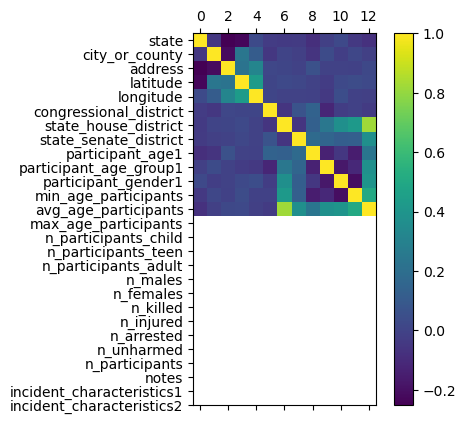

In [50]:
#plot matrix with different colors for correlation
plt.matshow(dp_df.corr())
#legend for correlation
#add names of columns
plt.yticks(range(len(dp_df.columns)), dp_df.columns)
plt.colorbar()
plt.show()
